# Homework 3  - Part B


###### Roll Number: 20100177

We'll start Part B by taking out a minute to thank creators of Tensorflow and Keras for making our lives easier. The goal of this home work is to design a convolutional neural network to classify images from CIFAR-10. CIFAR-10 is a subset of CIFAR-100 with 10 and 100 being number of classes. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. We'll be building small CNNs using Keras to solve this classification task.
<br>

Please note:
- You have to save each trained model weights and tensorboard logs in different folder. Use proper names for the model
- You have to show trainings in this notebook file, so make sure that the printings and figures are available on this notebook file
- This notebook is also your report file. So add your comments and analysis of each task. Your comments and analysis are as important as your code. This would be considered short report and it is compulsory part of the homework.
- Your system memory may overflow. In that case, please reset memory for trained model(s) keeping printed logs and history of trained model. History of all trained models could be used to plot the trends.
- For trends you shall also use tensorboard logs 

### Imports

In [76]:
import keras

from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from IPython.display import display

import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import os
import glob
your_id = 20100177
np.random.seed(your_id)
import imageio
import re



###### Hyperparameters

In [77]:
batch_size = 64
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
input_shape_cifar = (32,32,3)
images_dir = './cifar/'
epochs = 25
all_histories = []
model_names = []

### Task 1.1   Load dataset information
Download the [CIFAR-10 Dataset](https://drive.google.com/drive/folders/1FPsts3C2tJMVQ1xcCi2XZdb2z_J2OjSr?usp=sharing) and setup your working directory. Be sure to put the dataset in the <code>images_dir</code> directory. We won't be loading images and will only store the file paths in memory. These file paths will be used to load and return batch of images in our generator. Feel free to explore the dataset in this section.

In [78]:
train_dir = images_dir + 'train/'
test_dir = images_dir + 'test/'
label_dir = images_dir + 'labels.txt'

# Use either os.listdir or glob to generate an array of file paths for training and testing data (I would recommend using glob)
train_files = glob.glob(train_dir + '/*')
test_files = glob.glob(test_dir + '/*')
# Use labels.txt to store labels in an array/dict (NOTE: The line number corresponds to the actual label)
f = open(label_dir, 'r')
classes = f.read().split('\n')

# Use sci-kit learn's train_test_split method to generate a validation dataset from the training dataset
train_files, val_files = train_test_split(train_files, test_size=0.2)

### Task 1.2 Preprocessing
Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. 

###### Task 1.2.1 
In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.

In [79]:
#Simply divide each pixel value by 255
def preprocessing_norm(images):
    return np.true_divide(images, 255)

###### Task 1.2.2
Compute the channel-wise mean and standard deviation (std). Subtract channel-wise mean and divide by channel-wise std. This will shift the mean to zero and variation to 1 for each channel. 

In [80]:
#For Each channel compute the mean and stddev and shift it
def preprocessing_meanShift(images):
    for c in range(images.shape[3]):
        mean = np.mean(images[:,:,:,c])
        stddev = np.std(images[:,:,:,c])
        images[:,:,:,c] = (images[:,:,:,c] - mean) / stddev
    return images

### Task 1.3  Batch Generator
Previously, when training our models, we were loading the complete data in memory to fit our model. However, in practice we're working with very large datasets which cannot be loaded all at once in memory. As a solution, we use "Data Generators" which are essentially python generators that load batches of data from disk into memory and pass into our models. In order to achieve this, we only store filepaths that point to training/test samples in our dataset in memory. A data generator yields a tuple of (Xs,Ys) whenever the generator is used via the next() function. Implementation of a data generator is open ended, you can add whatever arguments you find necessary in addition to the ones provided.

In [81]:
#I used the LabelBinarizer instead of to_categorical because for some reason that wasn't working for me
lb = LabelBinarizer()
labels = list(map(lambda x: re.findall(r'_([a-z]+)', x)[0], train_files))
lb.fit(labels)
def data_generator(image_list , batch_size = 32, preprocessing = None):
    global lb

    while 1:
        for i in range(0, len(image_list), batch_size):    
            X = []
            y = []
            for j in range(i, min(i + batch_size, len(image_list))):
                im = imageio.imread(image_list[j])
                X.append(im)
                y.extend(re.findall(r'_([a-z]+)', image_list[j]))
            X = np.array(X)
            if preprocessing:
                X = preprocessing(X)
            yield (X, lb.transform(y))
    

### Task 1.4 Design CNN model
**IMPORTANT**: For each model you create, you need to conduct analysis in a markdown cell below the code cell containing the model's training. Your analysis should include plots, comments on its accuracy/loss, etc. Try to predict images and see what images your model is correctly classifying, see if your model is overfitting or not. For each layer you add, specify its function and then comment on its results.

In [82]:
# Design a CNN to predict classes for the images in the dataset. Try to keep your network shallow since you'll be training your model on your PC as well.
input_img = Input(shape=input_shape_cifar, name='input_img')
l = Conv2D(1, kernel_size=(4,4), activation='relu')(input_img)
l = Conv2D(10, (3,3), activation='relu')(l)
l = Flatten()(l)
l = Dense(128, activation='relu')(l)
output_class = Dense(len(classes), activation='softmax')(l)
model_initial = Model(inputs=input_img, outputs=output_class)

<h2>Analysis</h2>
<p>Model is getting a really high accuracy this might indicate that model is overfitting. I have created a very simple model that uses 2 Conv Layers and then Flattens it and then 1 Dense Layer before finally the outputlayer. Validation Accuracy is around 45% which indicates that model is overfitting to the training examples</p>

#### Compile model and plot

In [83]:
model_name = 'base_model'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
   

In [84]:
 # You may tweak the learning rate
adam = Adam(lr=0.001)

# Use the appropriate loss function and compile the model
model_initial.compile(loss='categorical_crossentropy',
              optimizer=adam, 
              metrics=['accuracy'])

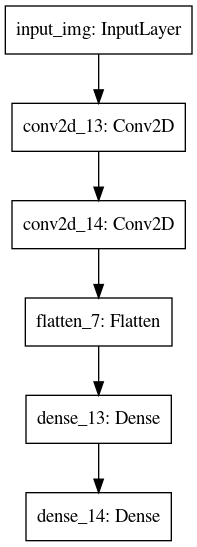

In [85]:
plot_model(model_initial, model_name+'/'+model_name+'.png')

In [86]:
model_initial.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 29, 1)         49        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 27, 27, 10)        100       
_________________________________________________________________
flatten_7 (Flatten)          (None, 7290)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               933248    
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
Total params: 934,687
Trainable params: 934,687
Non-trainable params: 0
____________________________________________________

#### Task 1.5 Training model
In order to train the model, instead of "model.fit" function, we will use the "model.fit_generator" function for training. For details check out [keras documentation](https://keras.io/models/sequential/)

In [87]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [88]:
# Add the following callbacks to your Model: ModelCheckpoin, CSVLogger, ReduceLROnPlateau. The callback for Tensorboard has already been provided to you.

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

#### Task 1.5.1 
Train model without using any pre-processing scheme

In [89]:
# Create three generators: For training your model, for validation, for testing.
train_data = data_generator(train_files, batch_size=batch_size)
test_data = data_generator(test_files, batch_size=batch_size)
val_data = data_generator(val_files, batch_size=batch_size)

In [90]:
# Start training your model here
hist_initial = model_initial.fit(train_data, steps_per_epoch=(len(train_files)//batch_size), epochs=epochs, validation_data=val_data, validation_steps=(len(val_files)//batch_size), callbacks=callbacks)
all_histories.append(hist_initial)
model_names.append(model_name)

Epoch 1/25
625/625 [==============================] - 14s 23ms/step - loss: 2.2787 - accuracy: 0.1301 - val_loss: 2.0776 - val_accuracy: 0.2208

Epoch 00001: val_loss improved from inf to 2.07763, saving model to base_model/base_model-01-2.08.h5
Epoch 2/25
625/625 [==============================] - 14s 22ms/step - loss: 1.8436 - accuracy: 0.3413 - val_loss: 1.5910 - val_accuracy: 0.4310

Epoch 00002: val_loss improved from 2.07763 to 1.59096, saving model to base_model/base_model-02-1.59.h5
Epoch 3/25
625/625 [==============================] - 14s 23ms/step - loss: 1.4040 - accuracy: 0.5092 - val_loss: 1.9423 - val_accuracy: 0.4260

Epoch 00003: val_loss did not improve from 1.59096
Epoch 4/25
625/625 [==============================] - 14s 23ms/step - loss: 1.0696 - accuracy: 0.6309 - val_loss: 1.6882 - val_accuracy: 0.4401

Epoch 00004: val_loss did not improve from 1.59096
Epoch 5/25
625/625 [==============================] - 14s 23ms/step - loss: 0.7742 - accuracy: 0.7365 - val_loss

#### Task 1.5.2 
Train model by using data preprocessing i.e normalization or mean shift. 

In [91]:
input_img = Input(shape=input_shape_cifar, name='input_img')
l = Conv2D(1, kernel_size=(4,4), activation='relu')(input_img)
l = Conv2D(10, (3,3), activation='relu')(l)
l = Flatten()(l)
l = Dense(128, activation='relu')(l)
output_class = Dense(len(classes), activation='softmax')(l)
model_preprocessed = Model(inputs=input_img, outputs=output_class)

<h2>Analysis</h2>
<p>Model is still getting a high accuracy but it is reduced compared to the last time. I didn't expect this result so I tried to run it multiple times just to make sure everything was okay. According to my understanding normalization should not have effect on the results but only on the speed that model is trained on. Model is identical to previous model with the addition of preprocessing the the data generators. The Validation loss improved from last time to being 55%</p>

In [92]:
model_name = 'model_preprocessed_input'

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)
    

In [93]:
# You may tweak this Learning Rate
adam = Adam(lr=0.001)

# Compile your model using an appropriate loss
model_preprocessed.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

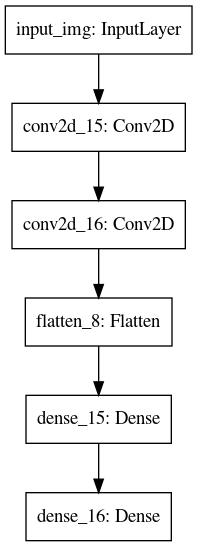

In [94]:
plot_model(model_preprocessed, model_name+'/'+model_name+'.png')

In [95]:
model_preprocessed.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 29, 1)         49        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 27, 27, 10)        100       
_________________________________________________________________
flatten_8 (Flatten)          (None, 7290)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               933248    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1290      
Total params: 934,687
Trainable params: 934,687
Non-trainable params: 0
____________________________________________________

In [96]:
# Add the following callbacks: ModelCheckpoint, CSVLogger. The callback for tensorboard has been provided to you.

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

In [97]:
# Create three generators again
train_data = data_generator(train_files, batch_size=batch_size, preprocessing=preprocessing_norm)
test_data = data_generator(test_files, batch_size=batch_size, preprocessing=preprocessing_norm)
val_data = data_generator(val_files, batch_size=batch_size, preprocessing=preprocessing_norm)

In [98]:
hist_preprocessed = model_preprocessed.fit(train_data, steps_per_epoch=(len(train_files)//batch_size), epochs=epochs, validation_data=val_data, validation_steps=(len(val_files)//batch_size), callbacks=callbacks)
all_histories.append(hist_preprocessed)
model_names.append(model_name)

Epoch 1/25
625/625 [==============================] - 15s 23ms/step - loss: 1.7993 - accuracy: 0.3447 - val_loss: 1.4080 - val_accuracy: 0.4485

Epoch 00001: val_loss improved from inf to 1.40796, saving model to model_preprocessed_input/model_preprocessed_input-01-1.41.h5
Epoch 2/25
625/625 [==============================] - 14s 23ms/step - loss: 1.3973 - accuracy: 0.5073 - val_loss: 1.2539 - val_accuracy: 0.4976

Epoch 00002: val_loss improved from 1.40796 to 1.25392, saving model to model_preprocessed_input/model_preprocessed_input-02-1.25.h5
Epoch 3/25
625/625 [==============================] - 14s 23ms/step - loss: 1.2364 - accuracy: 0.5692 - val_loss: 1.4169 - val_accuracy: 0.5165

Epoch 00003: val_loss did not improve from 1.25392
Epoch 4/25
625/625 [==============================] - 14s 23ms/step - loss: 1.1025 - accuracy: 0.6190 - val_loss: 1.3284 - val_accuracy: 0.5281

Epoch 00004: val_loss did not improve from 1.25392
Epoch 5/25
625/625 [==============================] - 14

### Task 2.1 Pooling
Now, you need to modify the model by adding pooling layer(s). Pooling could be average pooling or max pooling. You can use the size and stride for pooling of your choice. 
<br> 
Modify the network by introducing pooling layer and train the model using the __fit_generator__ function. 

In [99]:
model_name = 'model_pooling'

input_img = Input(shape=input_shape_cifar, name='input_img')
l = Conv2D(1, kernel_size=(4,4), activation='relu')(input_img)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Conv2D(10, (3,3), activation='relu')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Flatten()(l)
l = Dense(128, activation='relu')(l)
output_class = Dense(len(classes), activation='softmax')(l)
model_pooled = Model(inputs=input_img, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [100]:
adam = Adam(lr=0.001)
model_pooled.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [101]:
plot_model(model_pooled, model_name+'/'+model_name+'.png')
model_pooled.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 29, 1)         49        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 12, 12, 10)        100       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 10)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 360)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               462

In [102]:
# Add the following callbacks: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

In [103]:
# Create generators
train_data = data_generator(train_files, batch_size=batch_size)
test_data = data_generator(test_files, batch_size=batch_size)
val_data = data_generator(val_files, batch_size=batch_size)

In [104]:
hist_pooled = model_pooled.fit(train_data, steps_per_epoch=(len(train_files)//batch_size), epochs=epochs, validation_data=val_data, validation_steps=(len(val_files)//batch_size), callbacks=callbacks)
all_histories.append(hist_pooled)
model_names.append(model_name)

Epoch 1/25
625/625 [==============================] - 12s 19ms/step - loss: 3.5263 - accuracy: 0.1459 - val_loss: 2.2185 - val_accuracy: 0.1520

Epoch 00001: val_loss improved from inf to 2.21847, saving model to model_pooling/model_pooling-01-2.22.h5
Epoch 2/25
625/625 [==============================] - 12s 18ms/step - loss: 2.2314 - accuracy: 0.1709 - val_loss: 2.2005 - val_accuracy: 0.1759

Epoch 00002: val_loss improved from 2.21847 to 2.20053, saving model to model_pooling/model_pooling-02-2.20.h5
Epoch 3/25
625/625 [==============================] - 12s 19ms/step - loss: 2.1591 - accuracy: 0.2068 - val_loss: 2.0293 - val_accuracy: 0.2168

Epoch 00003: val_loss improved from 2.20053 to 2.02930, saving model to model_pooling/model_pooling-03-2.03.h5
Epoch 4/25
625/625 [==============================] - 12s 19ms/step - loss: 2.0284 - accuracy: 0.2605 - val_loss: 1.8486 - val_accuracy: 0.2812

Epoch 00004: val_loss improved from 2.02930 to 1.84862, saving model to model_pooling/model

<h2>Analysis</h2>
<p>In this model I introduced 2 Max Pooling Layers one after each Conv Layer. I expected this to decrease the performance of my model and it did. Since we are losing some information after each layer but it did speed up to process of training models. Accuracy Overall (both validation and training) decreased with being val: 46% and train: 65%</p>

### Task 3.1 Dropout
Modify the network by introducing dropout layer(s) and train the model using the __fit_generator__ function. 

In [105]:
model_name = 'model_dropout'

input_img = Input(shape=input_shape_cifar, name='input_img')
l = Conv2D(1, kernel_size=(4,4), activation='relu')(input_img)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Dropout(rate=0.25)(l)
l = Conv2D(10, (3,3), activation='relu')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Flatten()(l)
l = Dense(128, activation='relu')(l)
l = Dropout(rate=0.3)(l)
output_class = Dense(len(classes), activation='softmax')(l)
model_dropout = Model(inputs=input_img, outputs=output_class)

if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [106]:
adam = Adam(lr=0.001)
model_dropout.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [107]:
plot_model(model_dropout, model_name+'/'+model_name+'.png')
model_dropout.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 29, 29, 1)         49        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 1)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 12, 10)        100       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 10)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 360)               0  

In [108]:
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

In [134]:
# Create three Generators
train_data = data_generator(train_files, batch_size=batch_size)
test_data = data_generator(test_files, batch_size=batch_size)
val_data = data_generator(val_files, batch_size=batch_size)

In [135]:
hist_dropout = model_dropout.fit(train_data, steps_per_epoch=(len(train_files)//batch_size), epochs=epochs, validation_data=val_data, validation_steps=(len(val_files)//batch_size), callbacks=callbacks)
all_histories.append(hist_dropout)
model_names.append(model_name)

Epoch 1/25
625/625 [==============================] - 13s 20ms/step - loss: 5.9236 - accuracy: 0.1627 - val_loss: 2.2109 - val_accuracy: 0.1683

Epoch 00001: val_loss did not improve from 1.45312
Epoch 2/25
625/625 [==============================] - 12s 20ms/step - loss: 2.2779 - accuracy: 0.1642 - val_loss: 2.2958 - val_accuracy: 0.1682

Epoch 00002: val_loss did not improve from 1.45312
Epoch 3/25
625/625 [==============================] - 12s 20ms/step - loss: 2.2332 - accuracy: 0.1632 - val_loss: 2.2870 - val_accuracy: 0.1699

Epoch 00003: val_loss did not improve from 1.45312
Epoch 4/25
625/625 [==============================] - 12s 20ms/step - loss: 2.2114 - accuracy: 0.1623 - val_loss: 2.1213 - val_accuracy: 0.1744

Epoch 00004: val_loss did not improve from 1.45312
Epoch 5/25
625/625 [==============================] - 12s 19ms/step - loss: 2.1969 - accuracy: 0.1661 - val_loss: 2.1312 - val_accuracy: 0.1832

Epoch 00005: val_loss did not improve from 1.45312
Epoch 6/25
625/625 [

<h2>Analysis</h2>
<p>In this model I introduced dropout layers are the max pooling and it further degraded the results with accuracy getting down to 44% and validation accuracy coming down to 39%. It also increased the loss. Dropout did help prevent overfitting of the model as the training and validation models are pretty close to each other. Adding more complexity to the model would be a right step here</p>

### Task 4.1 Batch Normalization
Modify the network by introducing batch normalization layer(s) and train the model. 

In [136]:
model_name = 'model_batch_normalized'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

In [137]:
input_img = Input(shape=input_shape_cifar, name='input_img')
l = Conv2D(1, kernel_size=(4,4), activation='relu')(input_img)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Dropout(rate=0.25)(l)
l = BatchNormalization()(l)
l = Conv2D(10, (3,3), activation='relu')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = BatchNormalization()(l)
l = Flatten()(l)
l = Dense(128, activation='relu')(l)
l = Dropout(rate=0.3)(l)
l = BatchNormalization()(l)
output_class = Dense(len(classes), activation='softmax')(l)
model_normalized = Model(inputs=input_img, outputs=output_class)

In [138]:
adam = Adam(lr=0.001)
model_normalized.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [139]:
plot_model(model_normalized, model_name+'/'+model_name+'.png')
model_normalized.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 29, 29, 1)         49        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 1)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 1)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 1)         4         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 12, 12, 10)        100       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 10)          0  

In [140]:
# Add the following checkpoints: ModelCheckpoint, CSVLogger
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger]

In [141]:
# Create three generators
train_data = data_generator(train_files, batch_size=batch_size)
test_data = data_generator(test_files, batch_size=batch_size)
val_data = data_generator(val_files, batch_size=batch_size)

In [142]:
hist_normalized = model_normalized.fit(train_data, steps_per_epoch=(len(train_files)//batch_size), epochs=epochs, validation_data=val_data, validation_steps=(len(val_files)//batch_size), callbacks=callbacks)
all_histories.append(hist_normalized)
model_names.append(model_name)

Epoch 1/25
625/625 [==============================] - 12s 20ms/step - loss: 2.1026 - accuracy: 0.2596 - val_loss: 2.1152 - val_accuracy: 0.2622

Epoch 00001: val_loss improved from inf to 2.11516, saving model to model_batch_normalized/model_batch_normalized-01-2.12.h5
Epoch 2/25
625/625 [==============================] - 12s 19ms/step - loss: 1.7831 - accuracy: 0.3526 - val_loss: 1.9957 - val_accuracy: 0.3257

Epoch 00002: val_loss improved from 2.11516 to 1.99575, saving model to model_batch_normalized/model_batch_normalized-02-2.00.h5
Epoch 3/25
625/625 [==============================] - 12s 19ms/step - loss: 1.7123 - accuracy: 0.3805 - val_loss: 2.1096 - val_accuracy: 0.3306

Epoch 00003: val_loss did not improve from 1.99575
Epoch 4/25
625/625 [==============================] - 12s 20ms/step - loss: 1.6770 - accuracy: 0.3972 - val_loss: 1.9308 - val_accuracy: 0.3460

Epoch 00004: val_loss improved from 1.99575 to 1.93083, saving model to model_batch_normalized/model_batch_normaliz

<h2>Analysis</h2>
<p>In this model I introduced batch normalization layers after the dropout layers. Accuracy and Validation loss are similar compared to the last model (dropout). This was expected because normalization layers just generate a statistically equivalent data which just helps the training speed of the model. In this model Accuracy didn't improve much from the initial accuracy and it got stable pretty quickly so in normalization models we will not just have faster epochs but also lesser epochs required</p>

### Task 5.1 Comparison of all models
In this task you need to plot the loss and accuracy for all models and __discuss__ which model has better performance and why do you think so.

In [143]:
# Plot accuracy of all models
def plotHistory(histories, names, metric):
    plt.clf() 
    x_axis = list(range(epochs))
    for hist, name in zip(histories, names):
        plt.plot(x_axis, hist.history[metric], label=metric+'_'+name)
        plt.scatter(x_axis, hist.history[metric])
    plt.legend()
    plt.title(metric)
    plt.show()

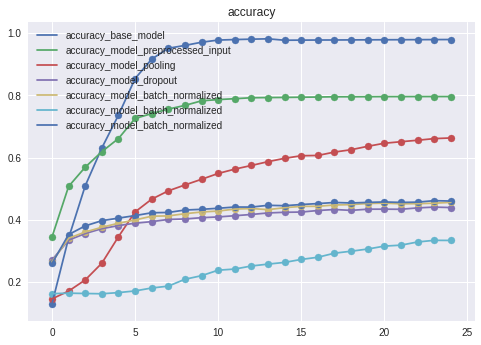

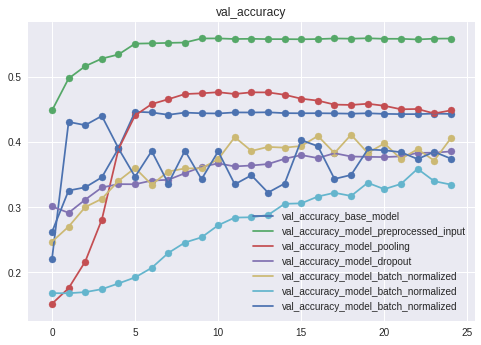

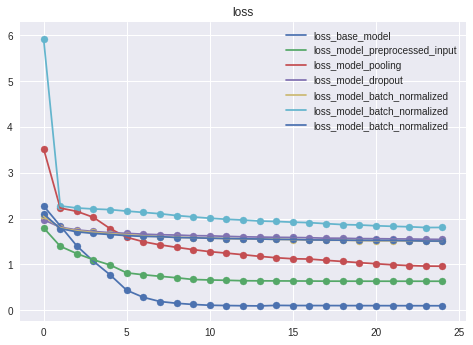

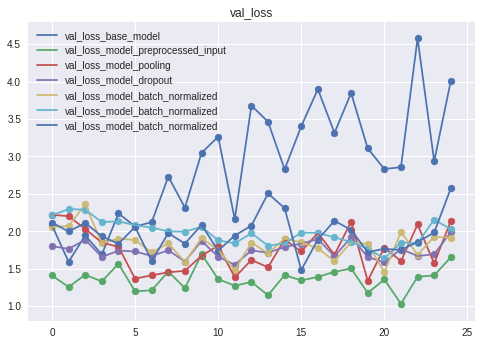

In [144]:
# Plot histories of all models
plotHistory(all_histories, model_names,'accuracy')
plotHistory(all_histories, model_names,'val_accuracy')
plotHistory(all_histories, model_names,'loss')
plotHistory(all_histories, model_names,'val_loss')

<h2>Analysis</h2>
<h3>Accuracy</h3>
<p>We see that as we keep adding layers and dropouts to the model this reduces the training accuracy which means that model is now not overfitting to the training data</p>
<h3>Validation Accuracy</h3>
<p>Preprocessed model has the highest validation accuracy compared to the rest of them which is surprising even to me. Initial model has a really bad validation accuracy which is explained by the fact that it was overfitting</p>
<h3>Loss</h3>
<p>Loss is in harmony with the accuracy of the model which is technically it's definition. Higher the accuracy lower the loss and vice versa</p>
<h3>Validation Loss</h3>
<p>Validation Loss is pretty similar for all models except base model in which it is spiking and pretty bluntly. This is expected result. To avoid overfitting we can add dropout layers to base model</p>

#### Tensorboard 
We will be covering Tensorboard in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020)

You can run TensorBoard using the following command
```tensorboard --logdir=path/to/log-directory
```
Now for logs of all above trained models, take snapshot of the _loss_ and _accuracy_ plots and save in the directory where this notebook is. To show that saved plot here in notebook use following command in _markdown_ cell. 
<br> __![](path_to_image)__

**Add cells to include loss plots**

##### Add your analysis here

In [145]:
print('Model Initial')
test_data = data_generator(test_files, batch_size=batch_size)
metrics = model_initial.evaluate(test_data, steps=(len(test_files)//batch_size))
for i in range(len(metrics)):
    print(model_initial.metrics_names[i], '-->', metrics[i])
print('Model Preprocessed')
test_data = data_generator(test_files, batch_size=batch_size, preprocessing=preprocessing_norm)
metrics = model_preprocessed.evaluate(test_data, steps=(len(test_files)//batch_size))
for i in range(len(metrics)):
    print(model_preprocessed.metrics_names[i], '-->', metrics[i])
print('Model Pooling')
test_data = data_generator(test_files, batch_size=batch_size)
metrics = model_pooled.evaluate(test_data, steps=(len(test_files)//batch_size))
for i in range(len(metrics)):
    print(model_pooled.metrics_names[i], '-->', metrics[i])
print('Model Dropout')
test_data = data_generator(test_files, batch_size=batch_size)
metrics = model_dropout.evaluate(test_data, steps=(len(test_files)//batch_size))
for i in range(len(metrics)):
    print(model_dropout.metrics_names[i], '-->', metrics[i])
print('Model Normalized')
test_data = data_generator(test_files, batch_size=batch_size)
metrics = model_normalized.evaluate(test_data, steps=(len(test_files)//batch_size))
for i in range(len(metrics)):
    print(model_normalized.metrics_names[i], '-->', metrics[i])

Model Initial
156/156 [==============================] - 2s 15ms/step
loss --> 3.7353508472442627
accuracy --> 0.43569710850715637
Model Preprocessed
156/156 [==============================] - 2s 15ms/step
loss --> 1.3535780906677246
accuracy --> 0.5502804517745972
Model Pooling
156/156 [==============================] - 2s 15ms/step
loss --> 2.3530237674713135
accuracy --> 0.4462139308452606
Model Dropout
156/156 [==============================] - 2s 15ms/step
loss --> 1.968778371810913
accuracy --> 0.32932692766189575
Model Normalized
156/156 [==============================] - 2s 15ms/step
loss --> 1.8809542655944824
accuracy --> 0.3802083432674408


<p>From test set evaluations above it shows that model_preprocessed is the best model among the rest as it maximizes the validation and test accuracy as well as minimizing the respective losses. Rest of the mo</p>

### Task 5.2 Visualize Activations
We will be covering this in Friday's tutorial. You can complete this part after the tutorial (21st Feb 2020). In this task, you are required to visualize the activations (outputs) of both the convolution layers of a model.

In [146]:
data_gen = data_generator(test_files)
images, labels = next(data_gen)
len(images), len(labels)

(32, 32)

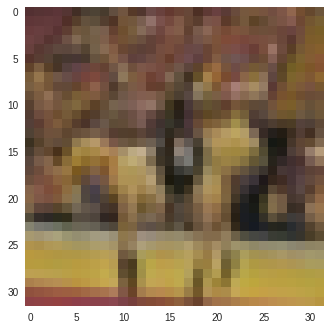

In [148]:
# Load any image here

test_image = images[0]

plt.imshow(test_image)
plt.gca().grid(False);

In [67]:

test_reshaped = test_image.reshape((1,32,32,3))

# Get a prediction from ANY ONE of your models and output its label
# model_dropout.predict(test_reshaped)
prediction= model_dropout.predict(test_reshaped).argmax()
lb.classes_[prediction]

'automobile'

In [71]:
# Create a Model from the Input layer to a Convolutional Layer
input_img = Input(shape=input_shape_cifar, name='input_img')
new_model = Model(inputs=input_img, outputs=model_initial.get_layer('conv2d_1').output)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_img:0", shape=(?, 32, 32, 3), dtype=float32) at layer "input_img". The following previous layers were accessed without issue: []

In [ ]:
# Get a prediction for your chosen image using this model
predicted_activations = new_model.predict(test_reshaped)
predicted_activations.shape

In [ ]:
# Use your predictions to visualise the activations
plt.matshow(con1_activations[0,:,:,0],cmap='viridis')
plt.show()
for i,ax in enumerate(axes.flatten()):
    ax.imshow(predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

In [ ]:
# Create another model to visualize activations from ANOTHER convolutional layer

In [ ]:
# You may rename this variable
second_predicted_activations = None

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15), dpi=80)
for i,ax in enumerate(axes.flatten()):
    ax.imshow(second_predicted_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

Q) What features from your chosen image do you think your model has been able to learn? In terms of filters (weights), what goes on when we add more convolutional layers in our models?

### Task 6.1  Effect of learning rate
Take the best selected model in __Task 5.1__ and change its learning rate to: 
- 6.1.1 any value between 5 and 1.
- 6.1.2 learning rate = any value between 0.6 and  0.1 
- 6.1.3 learning rate = 0.00001

and train these three models to compare the effect learning rate.

In [150]:
# Use code provided in previous tasks
input_img = Input(shape=input_shape_cifar, name='input_img')
l = Conv2D(1, kernel_size=(4,4), activation='relu')(input_img)
l = Conv2D(10, (3,3), activation='relu')(l)
l = Flatten()(l)
l = Dense(128, activation='relu')(l)
output_class = Dense(len(classes), activation='softmax')(l)
model_lr1 = Model(inputs=input_img, outputs=output_class)
adam = Adam(lr=2)

# Compile your model using an appropriate loss
model_lr1.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
callbacks = []
train_data = data_generator(train_files, batch_size=batch_size)
test_data = data_generator(test_files, batch_size=batch_size)
val_data = data_generator(val_files, batch_size=batch_size)
hist_lr1 = model_lr1.fit(train_data, steps_per_epoch=(len(train_files)//batch_size), epochs=epochs, validation_data=val_data, validation_steps=(len(val_files)//batch_size), callbacks=callbacks)

Epoch 1/25
625/625 [==============================] - 15s 23ms/step - loss: 205.8050 - accuracy: 0.1006 - val_loss: 2.4450 - val_accuracy: 0.1011
Epoch 2/25
625/625 [==============================] - 14s 23ms/step - loss: 2.4224 - accuracy: 0.1012 - val_loss: 2.5631 - val_accuracy: 0.1009
Epoch 3/25
625/625 [==============================] - 14s 23ms/step - loss: 2.4287 - accuracy: 0.1008 - val_loss: 2.4496 - val_accuracy: 0.1011
Epoch 4/25
625/625 [==============================] - 14s 23ms/step - loss: 2.4306 - accuracy: 0.1010 - val_loss: 2.4374 - val_accuracy: 0.1008
Epoch 5/25
625/625 [==============================] - 14s 23ms/step - loss: 2.4312 - accuracy: 0.1006 - val_loss: 2.4253 - val_accuracy: 0.1007
Epoch 6/25
625/625 [==============================] - 14s 23ms/step - loss: 2.4314 - accuracy: 0.1006 - val_loss: 2.5944 - val_accuracy: 0.1005
Epoch 7/25
625/625 [==============================] - 14s 23ms/step - loss: 2.4315 - accuracy: 0.1009 - val_loss: 2.4113 - val_accurac

In [151]:
input_img = Input(shape=input_shape_cifar, name='input_img')
l = Conv2D(1, kernel_size=(4,4), activation='relu')(input_img)
l = Conv2D(10, (3,3), activation='relu')(l)
l = Flatten()(l)
l = Dense(128, activation='relu')(l)
output_class = Dense(len(classes), activation='softmax')(l)
model_lr2 = Model(inputs=input_img, outputs=output_class)
adam = Adam(lr=0.2)

# Compile your model using an appropriate loss
model_lr2.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])
callbacks = []
train_data = data_generator(train_files, batch_size=batch_size)
test_data = data_generator(test_files, batch_size=batch_size)
val_data = data_generator(val_files, batch_size=batch_size)
hist_lr2 = model_lr2.fit(train_data, steps_per_epoch=(len(train_files)//batch_size), epochs=epochs, validation_data=val_data, validation_steps=(len(val_files)//batch_size), callbacks=callbacks)

Epoch 1/25
625/625 [==============================] - 15s 23ms/step - loss: 2.4388 - accuracy: 0.0976 - val_loss: 2.3498 - val_accuracy: 0.1005
Epoch 2/25
625/625 [==============================] - 14s 23ms/step - loss: 2.3185 - accuracy: 0.0984 - val_loss: 2.3510 - val_accuracy: 0.1005
Epoch 3/25
625/625 [==============================] - 14s 23ms/step - loss: 2.3187 - accuracy: 0.0979 - val_loss: 2.3427 - val_accuracy: 0.1003
Epoch 4/25
625/625 [==============================] - 14s 23ms/step - loss: 2.3187 - accuracy: 0.0981 - val_loss: 2.3230 - val_accuracy: 0.1007
Epoch 5/25
625/625 [==============================] - 14s 23ms/step - loss: 2.3188 - accuracy: 0.0986 - val_loss: 2.3331 - val_accuracy: 0.1002
Epoch 6/25
625/625 [==============================] - 14s 23ms/step - loss: 2.3188 - accuracy: 0.0987 - val_loss: 2.3378 - val_accuracy: 0.1006
Epoch 7/25
625/625 [==============================] - 14s 23ms/step - loss: 2.3188 - accuracy: 0.0987 - val_loss: 2.3210 - val_accuracy:

In [152]:
input_img = Input(shape=input_shape_cifar, name='input_img')
l = Conv2D(1, kernel_size=(4,4), activation='relu')(input_img)
l = Conv2D(10, (3,3), activation='relu')(l)
l = Flatten()(l)
l = Dense(128, activation='relu')(l)
output_class = Dense(len(classes), activation='softmax')(l)
model_lr3 = Model(inputs=input_img, outputs=output_class)
adam = Adam(lr=0.00001)

# Compile your model using an appropriate loss
model_lr3.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

callbacks = []
train_data = data_generator(train_files, batch_size=batch_size)
test_data = data_generator(test_files, batch_size=batch_size)
val_data = data_generator(val_files, batch_size=batch_size)
hist_lr3 = model_lr3.fit(train_data, steps_per_epoch=(len(train_files)//batch_size), epochs=epochs, validation_data=val_data, validation_steps=(len(val_files)//batch_size), callbacks=callbacks)

Epoch 1/25
625/625 [==============================] - 14s 23ms/step - loss: 2.3864 - accuracy: 0.1327 - val_loss: 2.2362 - val_accuracy: 0.1440
Epoch 2/25
625/625 [==============================] - 14s 23ms/step - loss: 2.2845 - accuracy: 0.1497 - val_loss: 2.3088 - val_accuracy: 0.1467
Epoch 3/25
625/625 [==============================] - 14s 23ms/step - loss: 2.2496 - accuracy: 0.1609 - val_loss: 2.2620 - val_accuracy: 0.1525
Epoch 4/25
625/625 [==============================] - 14s 23ms/step - loss: 2.2224 - accuracy: 0.1710 - val_loss: 2.3139 - val_accuracy: 0.1565
Epoch 5/25
625/625 [==============================] - 14s 23ms/step - loss: 2.1972 - accuracy: 0.1823 - val_loss: 2.2382 - val_accuracy: 0.1642
Epoch 6/25
625/625 [==============================] - 14s 23ms/step - loss: 2.1726 - accuracy: 0.1925 - val_loss: 2.3372 - val_accuracy: 0.1684
Epoch 7/25
625/625 [==============================] - 14s 23ms/step - loss: 2.1478 - accuracy: 0.2035 - val_loss: 2.3553 - val_accuracy:

<p>In model_lr1 (Learning rate 2) the accuracy dropped significantly from around 0.6 to 0.1 and validation loss decreased too. This means that model did not converge due to such an high learning rate. In model_lr2 (Learning rate 0.2) Accuracy decreased further. This result was a bit surprising for me as I was expecting model to converge but it performed a bit worse in terms of validation and train accuracy. In model_lr3 (Learning rate 0.00001) accuracy was much better compared the other models. It kept on increasing and if we had more epochs we would have much better accuracy and the model is just taking longer to converge. As we can see in every epoch accuracy increases

### Task 6.2 Plot loss and accuracy
Plot the loss and accracy for best model selected in task 5.1, and model trained in 6.1.1, 6.1.2 and 6.1.3 task. Give the detailed analysis of the effect of learning rate in your words and select the best learning rate for this problem.

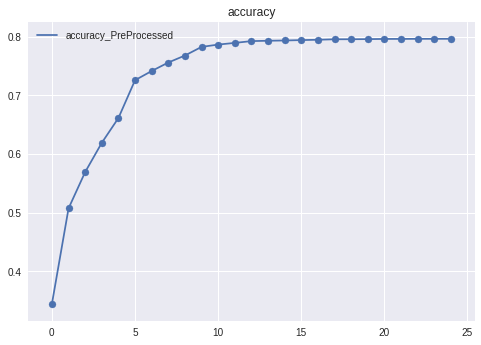

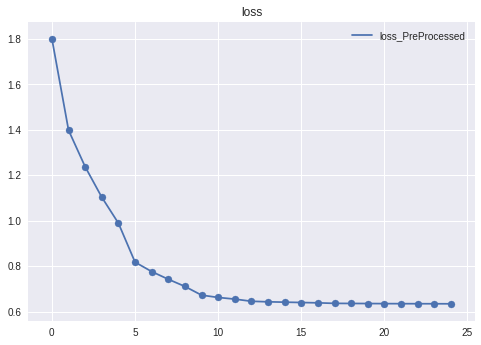

In [156]:
# Use plotHistory to make these plots
plotHistory([hist_preprocessed],['PreProcessed'],'accuracy')
plotHistory([hist_preprocessed],['PreProcessed'],'loss')

Analysis:The model's accuracy increases upto 80% and then after around 10-12 epochs it starts to stay constant 
Loss on the other hand exhibits similar properties and it actually still keeps on decreasing.